In [2]:
import time
from datetime import datetime
import pickle
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='year'>

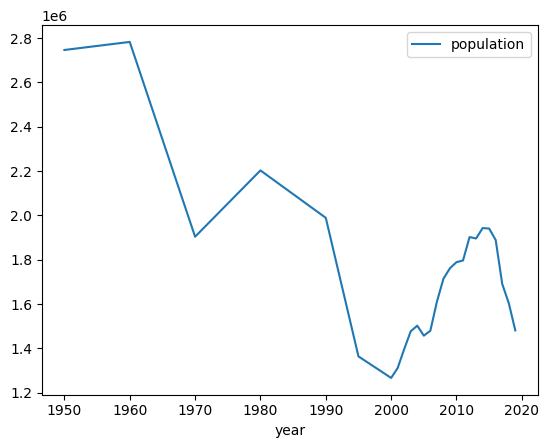

In [3]:
data_values = [
    2745997,
    2782353,
    1903713,
    2202779,
    1988858,
    1363806,
    1266800,
    1311604,
    1396967,
    1477301,
    1502477,
    1457376,
    1479637,
    1610122,
    1713947,
    1761687,
    1788948,
    1796629,
    1902084,
    1895822,
    1942683,
    1940579,
    1888729,
    1690307,
    1604344,
    1481074,
]

data_years = [
    1950,
    1960,
    1970,
    1980,
    1990,
    1995,
    2000,
    2001,
    2002,
    2003,
    2004,
    2005,
    2006,
    2007,
    2008,
    2009,
    2010,
    2011,
    2012,
    2013,
    2014,
    2015,
    2016,
    2017,
    2018,
    2019,
]

data = pd.DataFrame({"year": data_years, "population": data_values})

data["year"] = pd.to_datetime(data["year"], format="%Y")

# Установка индекса на 'year'
data.set_index("year", inplace=True)

# Интерполируем данные
interpolated_data = data.resample("YS").mean().interpolate(method="linear")

sns.lineplot(interpolated_data)

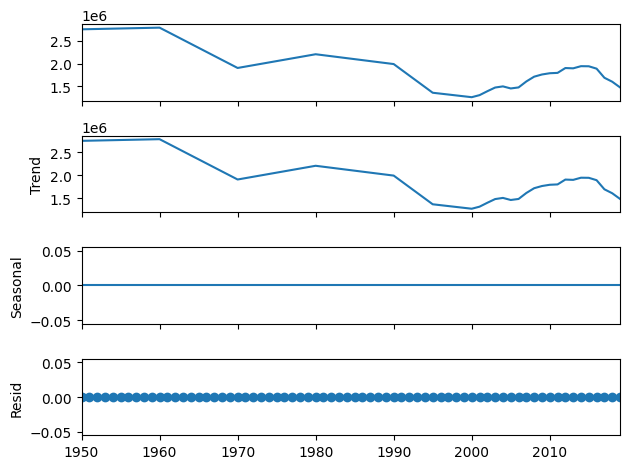

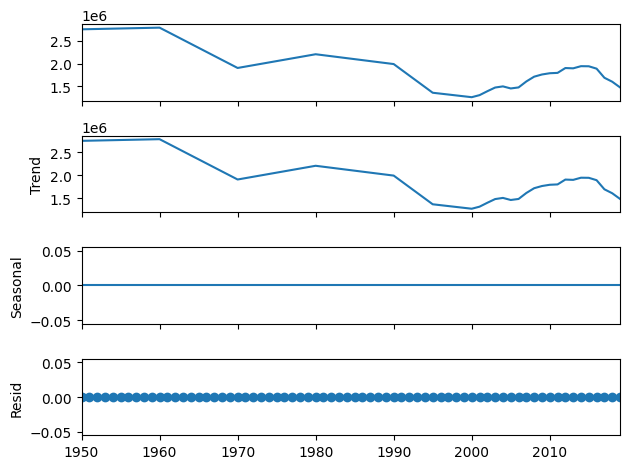

In [4]:
decompose = seasonal_decompose(interpolated_data)
decompose.plot()


In [5]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = adfuller(data)
    p_value = test[0]
    crit_value = test[4][crit_value]
    if p_value > crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

Единичных корней нет, ряд стационарен
{'p_value': -3.621950571736801, 'crit_value (5%)': -2.9110731481481484}


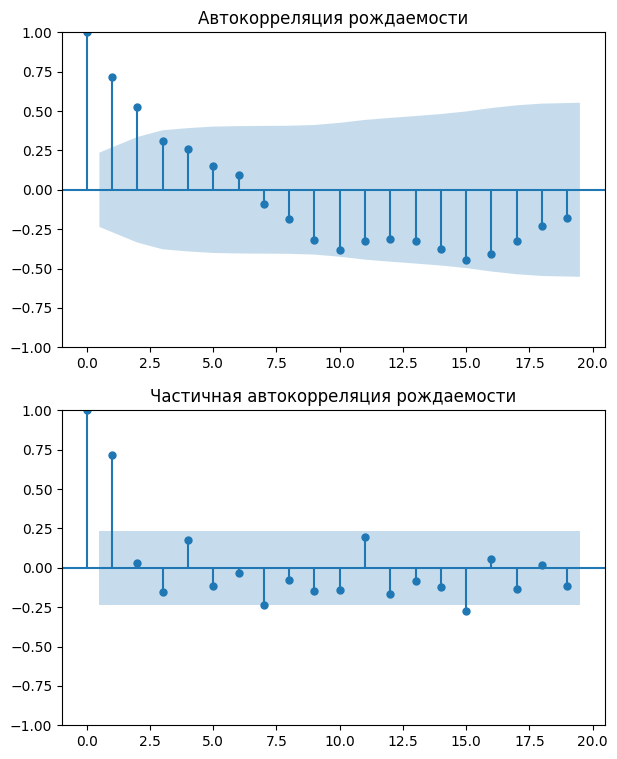

In [6]:
stationary_test(interpolated_data.diff().dropna(), name='рождаемости')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[26]             : AIC=1068.578, Time=0.96 sec
 ARIMA(0,1,0)(0,1,0)[26]             : AIC=1069.724, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[26]             : AIC=1067.179, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[26]             : AIC=1066.534, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[26]             : AIC=1066.128, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[26]             : AIC=1066.546, Time=0.18 sec
 ARIMA(0,1,1)(1,1,1)[26]             : AIC=inf, Time=1.09 sec
 ARIMA(1,1,1)(0,1,0)[26]             : AIC=1068.209, Time=0.14 sec
 ARIMA(0,1,2)(0,1,0)[26]             : AIC=1067.699, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[26]             : AIC=1066.907, Time=0.03 sec
 ARIMA(1,1,2)(0,1,0)[26]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[26] intercept   : AIC=1066.138, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,1,0)[26]          
Total fit time: 3.161 seconds
                                      SARIMAX Results                                

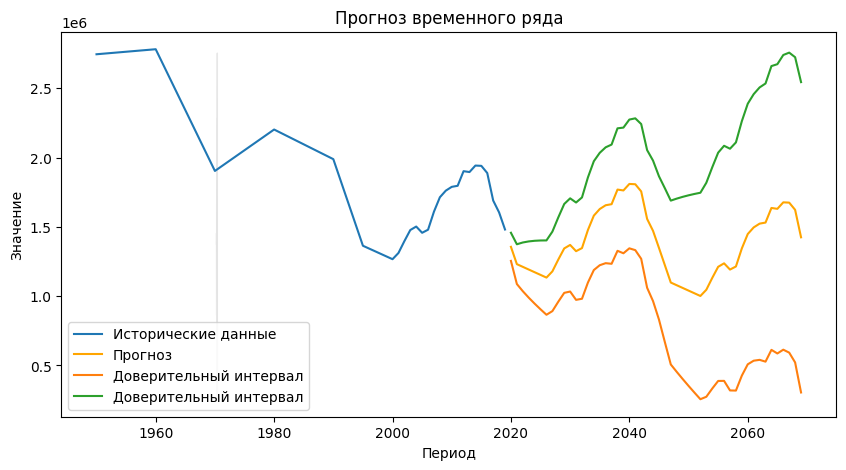

In [50]:
model_1 = pm.auto_arima(
    interpolated_data,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=26,
    max_q=26,
    m=26,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(model_1.summary())

# Прогнозирование
# Задаем количество периодов для прогнозирования
n_periods = 50  # например, прогноз на следующих 10 периодов
forecast, conf_int = model_1.predict(n_periods=n_periods, return_conf_int=True)

# Создаем индексы для прогнозируемых периодов, предполагаем, что индексы - это временные метки
index_of_fc = np.arange(len(interpolated_data), len(interpolated_data) + n_periods)

# Создаем DataFrame для визуализации результата
forecast_df = (
    pd.DataFrame(forecast)
    .reset_index()
    .set_axis(["year", "population"], axis=1)
    .set_index("year")
)

conf_int_df = pd.DataFrame(conf_int, index=forecast_df.index).set_axis(
    ["low_bound", "high_bound"], axis=1
)

# Визуализируем результаты
plt.figure(figsize=(10, 5))
plt.plot(interpolated_data, label="Исторические данные")
plt.plot(forecast_df, label="Прогноз", color="orange")
plt.plot(conf_int_df, label="Доверительный интервал")
plt.fill_between(
    index_of_fc, conf_int[:, 0], conf_int[:, 1], color="lightgray", alpha=0.5
)
plt.title("Прогноз временного ряда")
plt.xlabel("Период")
plt.ylabel("Значение")
plt.legend()
plt.show()

In [34]:
pd.DataFrame(conf_int, index=forecast_df.index).set_axis(["low_bound", "high_bound"], axis=1)

low_bound    high_bound
year                                  
2020-01-01  1.338898e+06  1.586586e+06
2021-01-01  1.269268e+06  1.619551e+06
2022-01-01  1.211573e+06  1.640581e+06
2023-01-01  1.160057e+06  1.655433e+06
2024-01-01  1.112489e+06  1.666337e+06
2025-01-01  1.067726e+06  1.674435e+06
2026-01-01  1.025088e+06  1.680409e+06
2027-01-01  9.841325e+05  1.684700e+06
2028-01-01  9.445520e+05  1.687616e+06
2029-01-01  9.061227e+05  1.689381e+06
2030-01-01  8.686755e+05  1.690164e+06
2031-01-01  8.320791e+05  1.690096e+06
2032-01-01  7.962292e+05  1.689281e+06
2033-01-01  7.610411e+05  1.687805e+06
2034-01-01  7.264449e+05  1.685737e+06

<Axes: xlabel='year'>

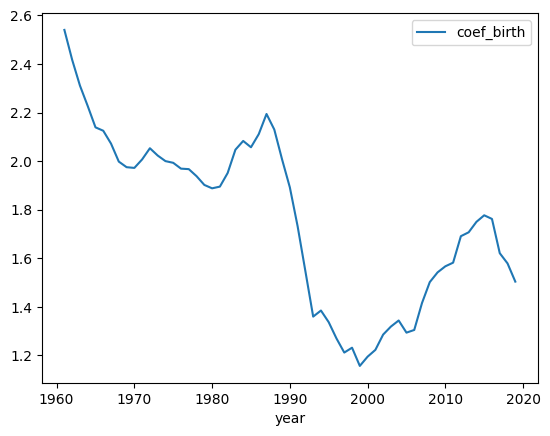

In [43]:
import pandas as pd

# Данные
data_birth_coef = {
    "year": [
        "1961", "1962", "1963", "1964", "1965",
        "1966", "1967", "1968", "1969", "1970",
        "1971", "1972", "1973", "1974", "1975",
        "1976", "1977", "1978", "1979", "1980",
        "1981", "1982", "1983", "1984", "1985",
        "1986", "1987", "1988", "1989", "1990",
        "1991", "1992", "1993", "1994", "1995",
        "1996", "1997", "1998", "1999", "2000",
        "2001", "2002", "2003", "2004", "2005",
        "2006", "2007", "2008", "2009", "2010",
        "2011", "2012", "2013", "2014", "2015",
        "2016", "2017", "2018", "2019"
    ],
    "coef_birth": [
        2.540, 2.417, 2.311, 2.227, 2.139,
        2.125, 2.072, 1.998, 1.975, 1.972,
        2.007, 2.053, 2.023, 2.000, 1.993,
        1.969, 1.967, 1.938, 1.902, 1.888,
        1.895, 1.951, 2.047, 2.083, 2.057,
        2.111, 2.194, 2.130, 2.007, 1.892,
        1.732, 1.547, 1.360, 1.385, 1.337,
        1.270, 1.212, 1.232, 1.157, 1.195,
        1.223, 1.286, 1.319, 1.344, 1.294,
        1.305, 1.416, 1.502, 1.542, 1.567,
        1.582, 1.691, 1.707, 1.750, 1.777,
        1.762, 1.621, 1.579, 1.504
    ]
}

# Создание DataFrame
df_birth = pd.DataFrame(data_birth_coef)
df_birth["year"] = pd.to_datetime(df_birth["year"], format="%Y")

# Установка индекса на 'year'
df_birth.set_index("year", inplace=True)
sns.lineplot(df_birth)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[26]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(0,1,0)[26]             : AIC=-69.286, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[26]             : AIC=-74.304, Time=0.48 sec
 ARIMA(0,1,1)(0,1,1)[26]             : AIC=-74.207, Time=0.45 sec
 ARIMA(1,1,0)(0,1,0)[26]             : AIC=-74.064, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[26]             : AIC=-72.304, Time=2.16 sec
 ARIMA(1,1,0)(1,1,1)[26]             : AIC=-72.304, Time=0.48 sec
 ARIMA(1,1,0)(0,1,1)[26]             : AIC=-74.302, Time=0.63 sec
 ARIMA(1,1,0)(2,1,1)[26]             : AIC=-70.304, Time=1.85 sec
 ARIMA(0,1,0)(1,1,0)[26]             : AIC=-70.470, Time=0.22 sec
 ARIMA(2,1,0)(1,1,0)[26]             : AIC=-72.636, Time=0.63 sec
 ARIMA(1,1,1)(1,1,0)[26]             : AIC=-72.690, Time=1.03 sec
 ARIMA(0,1,1)(1,1,0)[26]             : AIC=-74.207, Time=0.43 sec
 ARIMA(2,1,1)(1,1,0)[26]             : AIC=-70.709, Time=1.28 sec
 ARIMA(1,1,0)(1,1,0)[26] intercept   

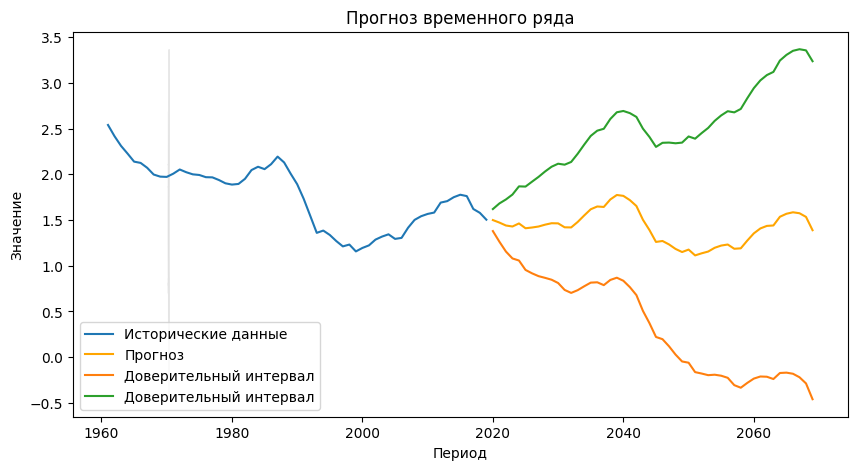

In [49]:
model_2 = pm.auto_arima(
    df_birth,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=20,
    max_q=20,
    m=26,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

print(model_2.summary())

# Прогнозирование
# Задаем количество периодов для прогнозирования
n_periods = 50  # например, прогноз на следующих 10 периодов
forecast, conf_int = model_2.predict(n_periods=n_periods, return_conf_int=True)

# Создаем индексы для прогнозируемых периодов, предполагаем, что индексы - это временные метки
index_of_fc = np.arange(len(df_birth), len(df_birth) + n_periods)

# Создаем DataFrame для визуализации результата
forecast_df = (
    pd.DataFrame(forecast)
    .reset_index()
    .set_axis(["year", "population"], axis=1)
    .set_index("year")
)

conf_int_df = pd.DataFrame(conf_int, index=forecast_df.index).set_axis(
    ["low_bound", "high_bound"], axis=1
)

# Визуализируем результаты
plt.figure(figsize=(10, 5))
plt.plot(df_birth, label="Исторические данные")
plt.plot(forecast_df, label="Прогноз", color="orange")
plt.plot(conf_int_df, label="Доверительный интервал")
plt.fill_between(
    index_of_fc, conf_int[:, 0], conf_int[:, 1], color="lightgray", alpha=0.5
)
plt.title("Прогноз временного ряда")
plt.xlabel("Период")
plt.ylabel("Значение")
plt.legend()
plt.show()

In [58]:
data = pd.read_excel("./data/Rus_ASFR1946-2022.xlsx",skiprows=2)
data.set_index("Year", inplace=True)
data

BraOAT15  BraOAT16  BraOAT17  BraOAT18  BraOAT19  BraOAT20  BraOAT21  \
Year                                                                         
1946  0.000120  0.000592  0.002903  0.013868  0.030835  0.069299  0.085201   
1947  0.000106  0.000673  0.003363  0.015761  0.037007  0.080704  0.100651   
1948  0.000109  0.000727  0.003624  0.018278  0.039577  0.089788  0.109598   
1949  0.000154  0.000881  0.004057  0.020623  0.042228  0.093976  0.113459   
1950  0.000210  0.001078  0.004510  0.020778  0.043971  0.093170  0.110963   
...        ...       ...       ...       ...       ...       ...       ...   
2018  0.001618  0.004321  0.010983  0.023493  0.042586  0.057116  0.069616   
2019  0.001570  0.004261  0.010403  0.021607  0.038143  0.053674  0.065577   
2020  0.001481  0.003945  0.010167  0.021457  0.036517  0.049231  0.064059   
2021  0.001448  0.003600  0.009406  0.020093  0.035242  0.047424  0.058399   
2022  0.001331  0.003178  0.008634  0.019977  0.035652  0.048495  0.058633   

      BraOAT22  BraOAT23  BraOAT24  ...  BraO5T46  BraO5T47  BraO5T48  \
Year                                ...                                 
1946  0.121567  0.138462  0.134834  ...  0.008667  0.003582  0.003284   
1947  0.138572  0.159027  0.164315  ...  0.006638  0.004228  0.002878   
1948  0.148647  0.166871  0.181062  ...  0.005334  0.003588  0.002797   
1949  0.154008  0.169608  0.186854  ...  0.005534  0.003372  0.002794   
1950  0.149862  0.165899  0.180116  ...  0.005904  0.003499  0.002578   
...        ...       ...       ...  ...       ...       ...       ...   
2018  0.077085  0.088227  0.095647  ...  0.000055  0.000019  0.000018   
2019  0.075732  0.082824  0.092845  ...  0.000072  0.000040  0.000007   
2020  0.075230  0.085306  0.092236  ...  0.000062  0.000026  0.000021   
2021  0.071705  0.082778  0.092582  ...  0.000091  0.000040  0.000012   
2022  0.067219  0.078886  0.089827  ...  0.000034  0.000013  0.000012   

      BraO5T49  BraO5T50  BraO5T51  BraO5T52  BraO5T53  BraO5T54  BraO5T55  
Year                                                                        
1946  0.002096  0.000679       NaN       NaN       NaN       NaN       NaN  
1947  0.001651  0.000528       NaN       NaN       NaN       NaN       NaN  
1948  0.001479  0.000399       NaN       NaN       NaN       NaN       NaN  
1949  0.001811  0.000378       NaN       NaN       NaN       NaN       NaN  
1950  0.001846  0.000404       NaN       NaN       NaN       NaN       NaN  
...        ...       ...       ...       ...       ...       ...       ...  
2018  0.000009  0.000002  0.000006  0.000004  0.000004  0.000002  0.000001  
2019  0.000005  0.000005  0.000004  0.000002  0.000001  0.000002  0.000004  
2020  0.000003  0.000007  0.000006  0.000005  0.000001  0.000002  0.000003  
2021  0.000012  0.000003  0.000003  0.000005  0.000000  0.000000  0.000006  
2022  0.000010  0.000001  0.000000  0.000003  0.000002  0.000001  0.000006  

[77 rows x 246 columns]

In [55]:
data.describe().to_excel("./data/agg.xlsx")

<Axes: xlabel='Year'>

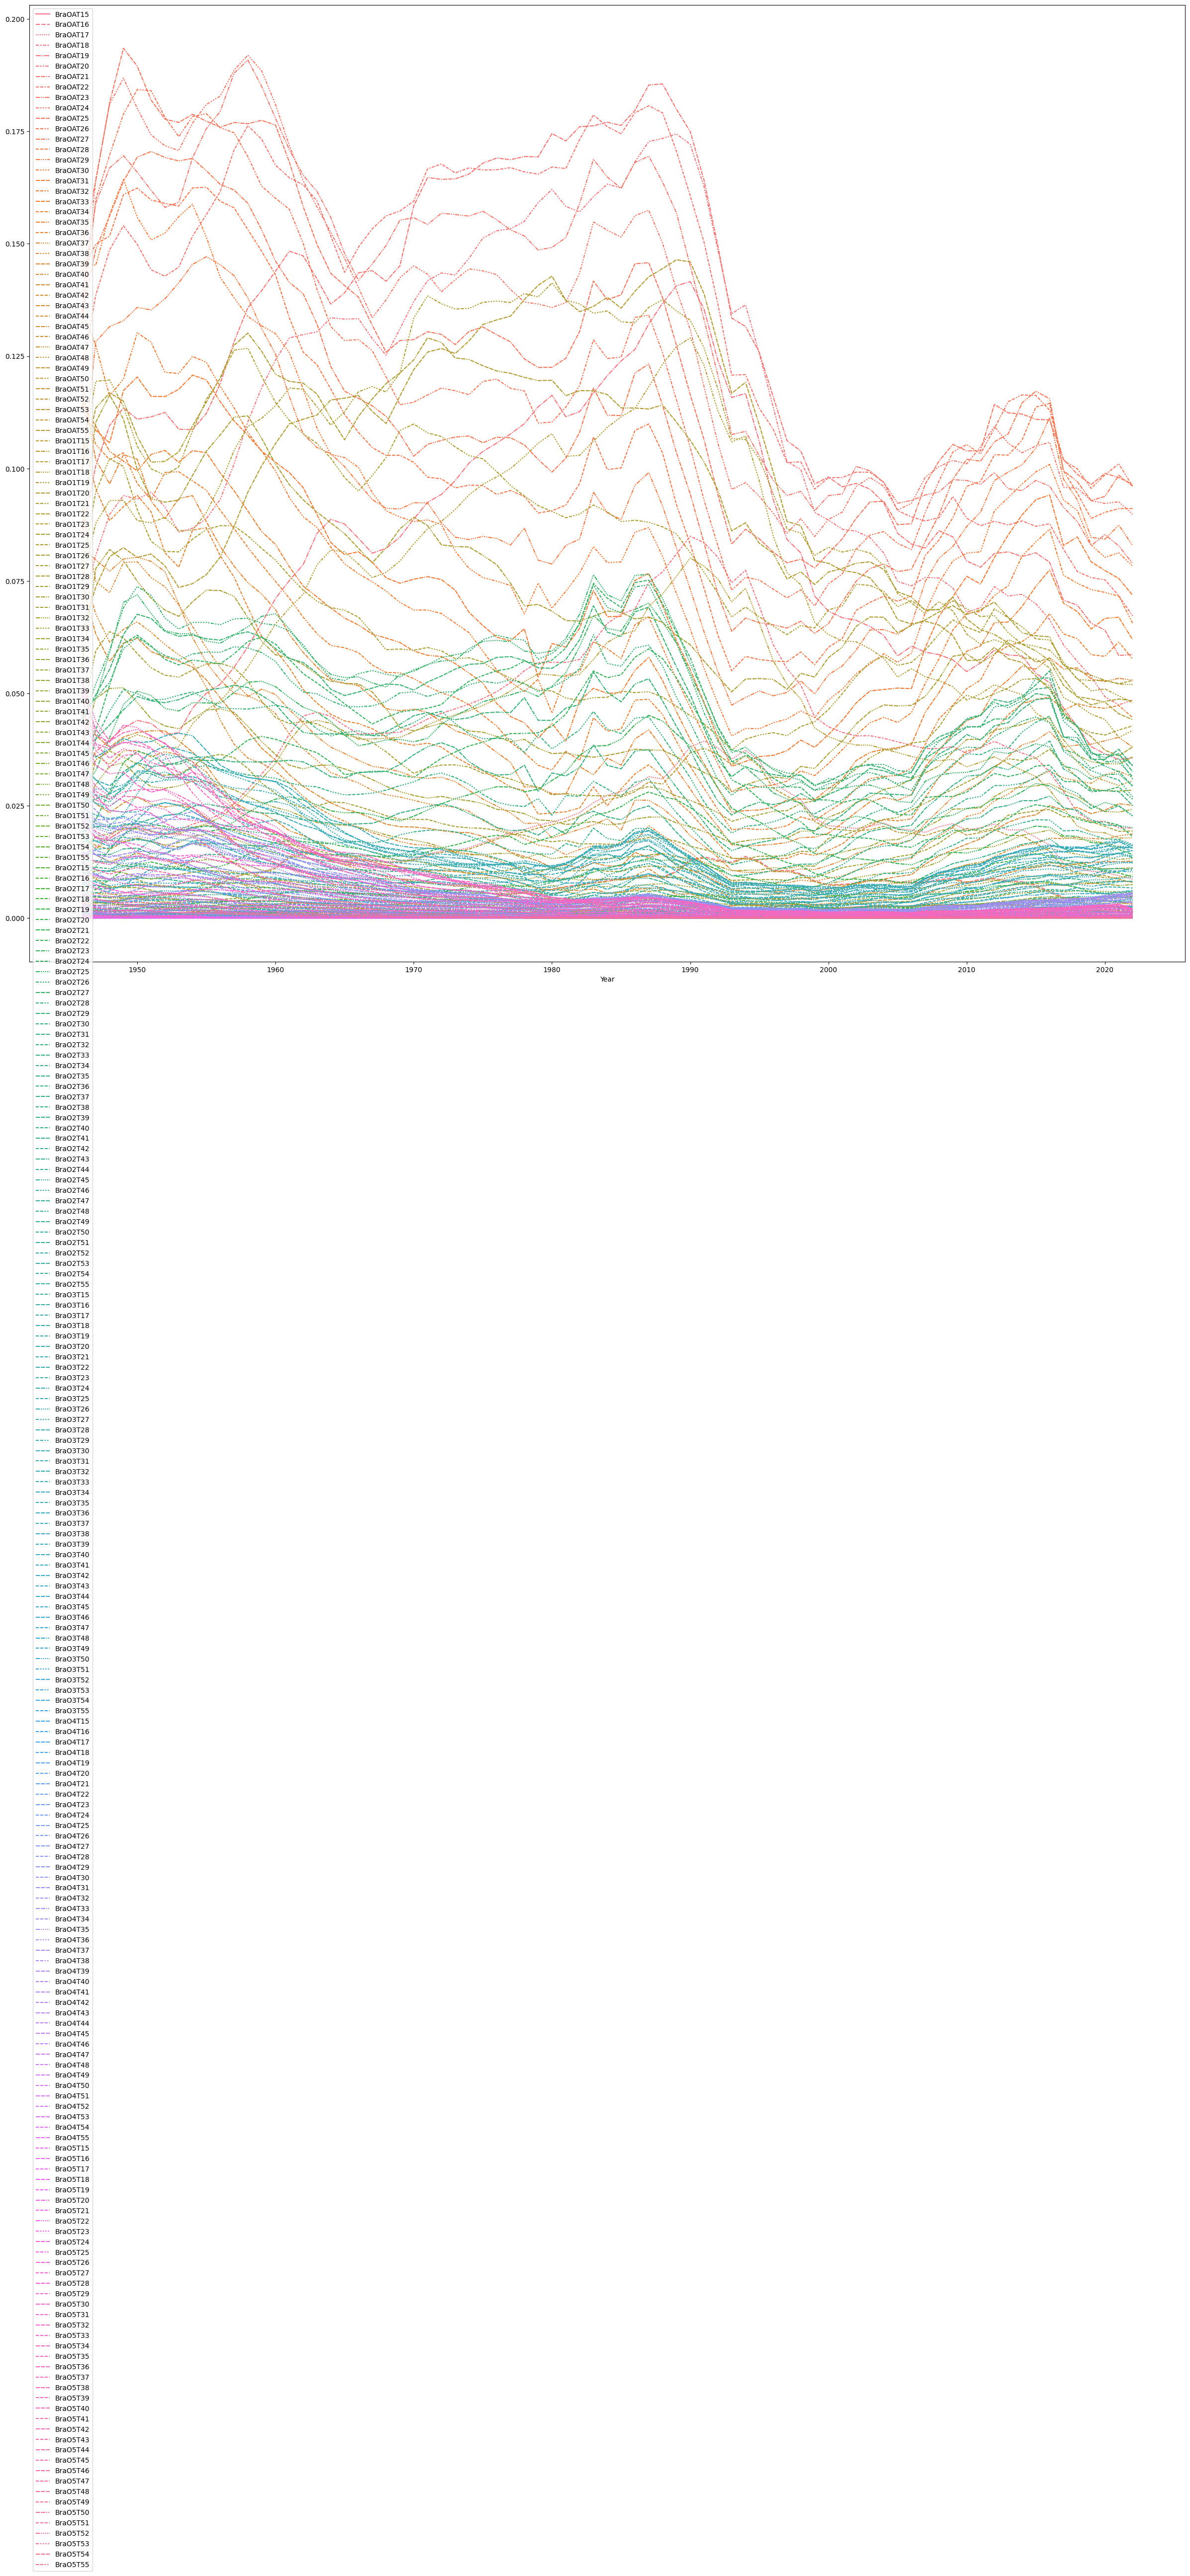

In [62]:
fig, axes = plt.subplots(1, 1, figsize=(30, 25))
sns.lineplot(data)